# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", module="e3nn")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pathlib
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch

from ase import Atoms
from ase.io.jsonio import encode
from ase.visualize.plot import plot_atoms

from mace.calculators import MACECalculator

from condevo.es.guidance import KNNNoveltyCondition

from cluster import load_lj_cluster, evaluate_lj_population_torch
from charlx import AtomsFixer, AtomsRelaxer, AtomsTSOptimizer, CHARLX
from condition import OriginCondition
from run import CorrectedApplyLimitsObjective, run_evo
from ase.visualize import view
from view import view_results

torch.set_default_dtype(torch.float64)

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);


def plot_atoms_without_axes(atoms, radii=None, rotation=None):
    fig, ax = plt.subplots()
    plot_atoms(atoms, ax=ax, radii=radii, rotation=rotation);
    ax.axis("off")



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


### helper funcs

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from ase.vibrations import Vibrations

def scan_and_plot_imaginary_mode(atoms, mode=0, steps=25, amplitude=3.0):
    """
    Scans the PES along the first imaginary mode and plots the result.
    """
    # 1. Run Vibrations to get the Hessian/Eigenvectors
    vib = Vibrations(atoms, name='ts_scan')
    vib.run()
    
    # Mode 0 is usually the most imaginary (largest negative freq)
    mode_vec = vib.get_mode(mode) 
    original_pos = atoms.get_positions().copy()
    
    displacements = np.linspace(-amplitude, amplitude, steps)
    energies = []

    #print("Starting displacement scan...")
    for d in displacements:
        atoms.set_positions(original_pos + d * mode_vec)
        # Ensure your atoms object has a calculator attached!
        e = atoms.get_potential_energy()
        energies.append(e)
        print(f"Displacement: {d:6.3f} | Energy: {e:10.6f} eV")

    # Reset atoms to original TS structure
    atoms.set_positions(original_pos)
    vib.clean()

    # 2. Plotting the results
    plt.figure(figsize=(8, 5))
    plt.plot(displacements, energies, 'o-', color='#2c3e50', linewidth=2)
    
    # Highlighting the TS point
    plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='Original TS')
    
    plt.title("PES Scan Along Imaginary Mode (Saddle Point Cross-Section)")
    plt.xlabel("Displacement along Eigenvector (Å)")
    plt.ylabel("Potential Energy (eV)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.show()

    return displacements, energies

In [43]:
from ase.vibrations import Vibrations
import h5py

def check_saddle_point(atoms, eval_tol=1e-3):
    """
    Quantifies saddle point quality using both mass-weighted frequencies 
    and raw Hessian eigenvalues.
    """
    # 1. Run the vibration analysis
    vib = Vibrations(atoms)
    vib.run()
    
    # 2. Vibrational Frequency Analysis (Mass-Weighted)
    freqs = vib.get_frequencies()
    # In ASE, imaginary frequencies are returned as complex numbers (e.g., 0+500j)
    imaginary_freqs = [f for f in freqs if np.iscomplex(f)]
    
    # 3. Raw Hessian Analysis (Curvature only, no mass)
    hessian_raw = vib.get_vibrations().get_hessian_2d()

    # Eigenvalues of the raw Hessian (units: eV/Angstrom^2)
    raw_evals = np.linalg.eigvalsh(hessian_raw)
    
    # Count negative eigenvalues (ignoring tiny numerical noise near 0)
    # A threshold of -1e-5 is usually safe to separate noise from real curvature
    negative_evals = [val for val in raw_evals if val < -eval_tol]
    
    results = {
        "is_saddle_point": len(negative_evals) == 1,
        
        # Vibrational data
        "n_imaginary_freqs": len(imaginary_freqs),
        "imaginary_freq_val": imaginary_freqs[0] if imaginary_freqs else None,
        "all_freqs_cm1": np.round(freqs, 3),
        
        # Raw Hessian data
        "n_negative_evals": len(negative_evals),
        "raw_eigenvalues": np.round(raw_evals, 3),
        "lowest_eval": raw_evals[0]
    }
    
    # Clean up ASE temporary files
    vib.clean()
    
    return results



def analyze_es_energy_groups(h5_filename, run_id=0, energy_tolerance=0.01, plot=True):
    """
    Analyzes ES results by grouping structures with similar energy levels.
    Uses actual (negative) energies from the optimization.
    
    Args:
        h5_filename: Path to HDF5 output file from run_evo()
        run_id: Run ID to analyze (default: 0 for first run)
        energy_tolerance: Energy threshold (in eV) for grouping similar structures
        plot: Whether to plot the results
    
    Returns:
        Dictionary with analysis of energy groups
    """
    with h5py.File(h5_filename, 'r') as f:
        run_group = f[f'run_{run_id}']
        
        all_fitness = []
        best_fitness_per_gen = []
        all_samples = []
        
        # Iterate through generations
        n_gens = len([k for k in run_group.keys() if k.startswith('gen_')])
        
        for gen_idx in range(n_gens):
            gen_group = run_group[f'gen_{gen_idx}']
            fitness = gen_group['fitness'][:]
            samples = gen_group['samples'][:]
            
            # Use negative energy (actual minimization direction)
            all_fitness.extend(-fitness)
            all_samples.append(samples)
            best_fitness_per_gen.append(-np.max(fitness))  # More negative = lower energy
        
        all_fitness = np.array(all_fitness)
        all_samples = np.concatenate(all_samples, axis=0)
    
    # Group structures by similar energy levels
    energy_groups = []
    sorted_indices = np.argsort(all_fitness)  # Sort lowest energy first
    
    for idx in sorted_indices:
        energy = all_fitness[idx]
        
        # Check if this energy belongs to any existing group
        assigned = False
        for group_energy, group_indices in energy_groups:
            if abs(energy - group_energy) < energy_tolerance:
                assigned = True
                group_indices.append(idx)
                break
        
        if not assigned:
            # Create new energy group
            energy_groups.append((energy, [idx]))
    
    print(f"\n{'='*70}")
    print(f"Energy Group Analysis - Run {run_id}")
    print(f"{'='*70}")
    print(f"Total samples evaluated: {len(all_fitness)}")
    print(f"Energy groups found: {len(energy_groups)}")
    print(f"Energy range: {np.min(all_fitness):.6f} to {np.max(all_fitness):.6f} eV")
    print(f"Energy std dev: {np.std(all_fitness):.6f} eV")
    print(f"Energy tolerance: {energy_tolerance} eV")
    print(f"\nEnergy groups (sorted by energy):")
    print(f"{'Rank':<6} {'Energy (eV)':<18} {'Count':<8} {'Frequency':<12}")
    print(f"{'-'*70}")
    
    for rank, (energy, indices) in enumerate(energy_groups, 1):
        count = len(indices)
        frequency = count / len(all_fitness) * 100
        print(f"{rank:<6} {energy:<18.6f} {count:<8} {frequency:>6.2f}%")
    
    print(f"{'='*70}\n")
    
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: All energies histogram
        ax = axes[0, 0]
        ax.hist(all_fitness, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of All Samples (Negative Energy)')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Best energy per generation
        ax = axes[0, 1]
        ax.plot(best_fitness_per_gen, 'o-', color='darkgreen', linewidth=2, markersize=8)
        ax.set_xlabel('Generation')
        ax.set_ylabel('Best Energy (eV)')
        ax.set_title('Convergence: Best Energy per Generation')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Energy groups
        ax = axes[1, 0]
        group_energies = [e for e, _ in energy_groups]
        group_counts = [len(indices) for _, indices in energy_groups]
        bars = ax.bar(range(len(group_energies)), group_energies, color='coral', edgecolor='black')
        ax.set_xlabel('Energy Group Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title(f'Identified Energy Groups (n={len(energy_groups)})')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for bar, count in zip(bars, group_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Energy vs sample index
        ax = axes[1, 1]
        ax.scatter(range(len(all_fitness)), all_fitness, alpha=0.5, s=20, color='navy')
        ax.axhline(np.min(all_fitness), color='red', linestyle='--', label='Best')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title('Energy Landscape Across Samples')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'all_energies': all_fitness,
        'best_energy_per_gen': best_fitness_per_gen,
        'energy_groups': energy_groups,
        'n_groups': len(energy_groups),
        'energy_range': (np.min(all_fitness), np.max(all_fitness)),
        'energy_std': np.std(all_fitness),
        'energy_tolerance': energy_tolerance
    }

### testing sella, TS opt

In [ ]:
N_ATOMS = 7

seeds = np.arange(5)

opt_structs = []
opt_data = []

import gc
import glob
import os

for i, seed in enumerate(seeds):

    print(f"\n{'='*70}")
    print(f"Iteration {i+1}/{len(seeds)} - Seed {seed}")
    print(f"{'='*70}")

    gc.collect()
    
    # Clean up any temporary files from previous iteration
    for pattern in ['vib_*', 'ts_check*', 'ts_scan*']:
        for f in glob.glob(pattern):
            try:
                if os.path.isfile(f):
                    os.remove(f)
                elif os.path.isdir(f):
                    shutil.rmtree(f)
            except:
                pass

    # Initialize founder structure
    lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
        n_atoms=N_ATOMS,
        wales_path=pathlib.Path("data/wales"),
        randomize=True,
        random_seed=seed,
    )
    founder = Atoms(symbols, np.reshape(lj_cluster_rand, (-1, 3)))

    from ase.calculators.lj import LennardJones
    founder.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    fixer = AtomsFixer(
        fix_func="get_fixed_by_list",
        fix_list=[],
        fix_axis=None,
        fix_threshold=None,
    )

    opt_atoms = founder.copy()

    steps = 1e6

    opt_atoms.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    ts_optimizer = AtomsTSOptimizer(
        founder_atoms=opt_atoms,
        fixer=fixer,
        calc="LJ",
        fmax=1e-3,
        steps=steps,
        logfile=None,
        multiproc=True,
        n_proc=16,
        device="cpu",
        e_cutoff=-500,
        progress_bar=True,
    )

    opt_atoms = ts_optimizer.optimize_atoms(opt_atoms, steps)
    opt_atoms.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    opt_structs.append(opt_atoms)
    opt_data.append(check_saddle_point(opt_atoms))


Iteration 1/5 - Seed 0

Iteration 2/5 - Seed 1

Iteration 2/5 - Seed 1

Iteration 3/5 - Seed 2

Iteration 3/5 - Seed 2

Iteration 4/5 - Seed 3

Iteration 4/5 - Seed 3

Iteration 5/5 - Seed 4

Iteration 5/5 - Seed 4


In [38]:
mode_vals = []
all_eigs = []

for dat in opt_data:
    mode_vals.append(dat["imaginary_freq_val"])
    all_eigs.append(dat["raw_eigenvalues"])

np.mean(mode_vals)
all_eigs = np.concatenate(all_eigs)


In [61]:
atoms1 = opt_structs[4]

In [62]:
atoms1.get_potential_energy()

np.float64(-15.44473379865136)

In [104]:
from sella import IRC

# function that follows internal reaction coordinate towards minima in both directions
def run_irc(atoms : Atoms, dx : float = 0.1, steps : int = 1000):
    ts_atoms = atoms.copy()
    ts_atoms.calc = atoms.calc

    min_energies = []
    

    irc_fw = IRC(ts_atoms, dx=dx, trajectory="irc_fw.traj")

    irc_fw.run(steps=steps, direction="forward")

    min_energies.append(ts_atoms.get_potential_energy())
    min_state_1 = ts_atoms.copy()

    ts_atoms.set_positions(atoms.get_positions())
    irc_bw = IRC(ts_atoms, dx=dx, trajectory="irc_bw.traj")
    irc_bw.run(steps=steps, direction="reverse")

    min_energies.append(ts_atoms.get_potential_energy())
    min_state_2 = ts_atoms.copy()

    return min_energies, (min_state_1, min_state_2)

In [105]:
minengs, minstates = run_irc(opt_structs[0])

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred


     Step     Time          Energy          fmax
IRC:    0 16:11:21      -15.026438        0.000627
IRC:    1 16:11:21      -15.027503        0.081947
IRC:    2 16:11:21      -15.030674        0.160892
IRC:    3 16:11:21      -15.035931        0.238017
IRC:    4 16:11:21      -15.043266        0.314631
IRC:    5 16:11:21      -15.052683        0.391026
IRC:    6 16:11:21      -15.064194        0.467362
IRC:    7 16:11:21      -15.077822        0.543610
IRC:    8 16:11:21      -15.093601        0.621825
IRC:    9 16:11:21      -15.111573        0.700164
IRC:   10 16:11:21      -15.131785        0.780492
IRC:   11 16:11:21      -15.154293        0.861781
IRC:   12 16:11:21      -15.179156        0.944948
IRC:   13 16:11:21      -15.206437        1.029586
IRC:   14 16:11:21      -15.236197        1.115854
IRC:   15 16:11:21      -15.268491        1.203051
IRC:   16 16:11:21      -15.303365        1.290792
IRC:   17 16:11:21      -15.340849        1.377643
IRC:   18 16:11:21      -15.38094

In [106]:
def plot_sella_irc(fwd_traj, bwd_traj):
    """
    Combines forward and backward IRC trajectories for a complete plot.
    """
    fwd_configs = read(fwd_traj, index=':')
    bwd_configs = read(bwd_traj, index=':')
    
    # Reverse backward configs so they lead TO the TS
    full_path = bwd_configs[::-1] + fwd_configs[1:]
    
    energies = [at.get_potential_energy() for at in full_path]
    # Normalize energies so Reactant (first frame) is 0
    energies = np.array(energies) - energies[0]
    
    steps = np.arange(len(full_path))
    
    plt.figure(figsize=(8, 5))
    plt.plot(steps, energies, color='#1f77b4', lw=2)
    plt.scatter(steps, energies, c=energies, cmap='viridis')
    
    # Find the peak (the TS)
    ts_idx = np.argmax(energies)
    plt.annotate('Transition State', xy=(ts_idx, energies[ts_idx]), 
                 xytext=(ts_idx, energies[ts_idx]+0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.title("IRC Energy Profile")
    plt.xlabel("Step Number")
    plt.ylabel("Relative Energy (eV)")
    plt.grid(True, alpha=0.3)
    plt.show()

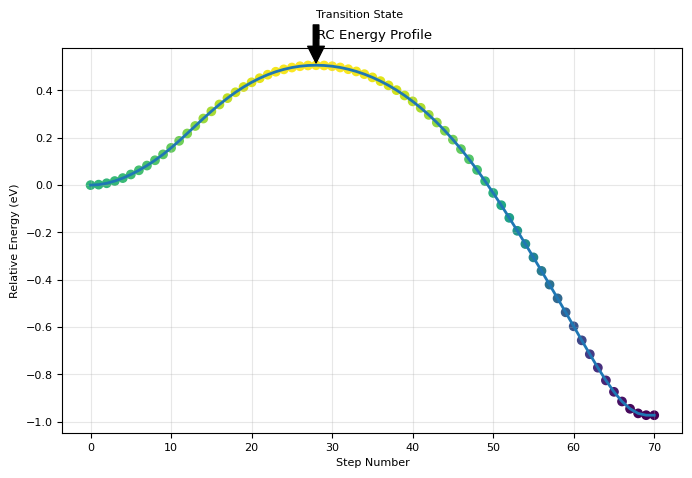

In [107]:
plot_sella_irc("irc_fw.traj", "irc_bw.traj")

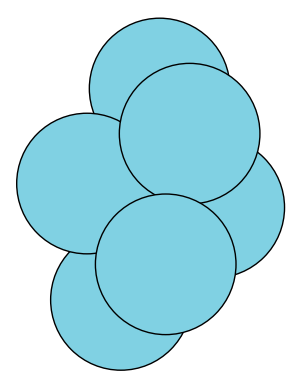

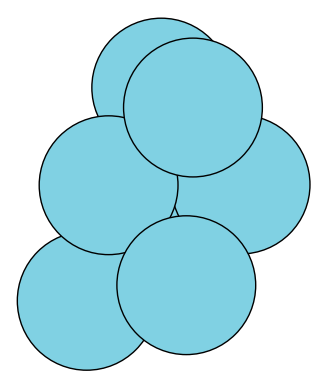

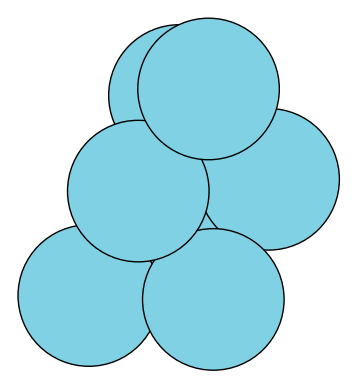

In [90]:
rotation = ""
radii = 0.5
plot_atoms_without_axes(minstates[0], radii=radii, rotation=rotation)
plot_atoms_without_axes(opt_structs[0], radii=radii, rotation=rotation),
plot_atoms_without_axes(minstates[1], radii=radii, rotation=rotation)

## 1. Lennard-Jones (LJ) cluster

The first example is a CHARLX evolution of the Lennard-Jones cluster with 13 atoms (LJ-13). The coordinates for the global minimum are loaded from files saved in the directory `data/wales/`. Files for clusters with 13, 31 and 38 atoms are available, other files with clusters up to 150 atoms can be downloaded as a `.tar` file from `https://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html`. After loading, additional information is shown: `max_span` (the maximum span of the structure used for conditioning), `dimensions` (number of atoms times three), `symbols` (chemical symbols for the `ase.atoms.Atoms` object) and `rep` (string representation for the destination path of the evolution). Also given is the energy of the structure, calculated by the `evaluate_lj_population_torch()` function, together with a visualiation of the cluster. For an interactive plot, comment in the last line `view(lj_atoms);`.

### Founder

We can now start with the configuration of the evolution. First, we define the randomized LJ-13 cluster from above as the `founder` structure for our evolution.

In [148]:
N_ATOMS = 7 # 13, 31, 38

# Initialize founder structure
lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=0,
)
founder = Atoms(symbols, np.reshape(lj_cluster_rand, (-1, 3)))

#plot_atoms_without_axes(founder)

In [129]:
# Initialize fixing parameters
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

fixed_indices, frozen_indices, free_indices = fixer.get_indices(founder)



# Initialize relaxing parameters
relaxer = AtomsRelaxer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    optimizer="FIRE",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)

####################################
# Initialize TS optimizer

ts_optimizer = AtomsTSOptimizer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)


# Initialize condition around the origin
condition_obj = OriginCondition(
    n_atoms=relaxer.free_n_atoms,
    target=1.0,
    kwargs={"cond_threshold": max_span},
)

# Initialize evolutionary algorithm
es = CHARLX
es_config = dict(
    x0=relaxer.free_positions,
    fixer=fixer,
    relaxer=relaxer,
    conditions=(condition_obj, KNNNoveltyCondition()),
    popsize=32,
    n_gens=10,
    sigma_init=1.5,
    selection_pressure=20.0,
    elite_ratio=0.15,
    crossover_ratio=0.125,
    mutation_rate=0.05,
    diff_batch_size=256,
    diff_max_epoch=1000,
    buffer_size=1000,
    is_genetic_algorithm=True,
    adaptive_selection_pressure=True,
    readaptation=False,
    forget_best=False,
)

# Initialize neural network
nn = "MLP"
nn_config = dict(
    num_hidden=96,
    num_layers=8,
    activation="LeakyReLU",
    num_params=relaxer.dimensions,
    num_conditions=len(es_config["conditions"]),
)

# Initialize diffusion model
diff = "GGDDIM"
diff_config = dict(
    num_steps=5000,
    lamba_range=1.0,
    geometry="radial",
    axis=None,
    lower_threshold=0.0,
    upper_threshold=max_span*1.5,
    diff_origin=[0.0, 0.0, 0.0],
    overlap_penalty=True,
    train_on_penalty=True,
)


# Initialize objective that will be maximized
obj = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="evaluate_population_with_calc",
    foo_kwargs={"obj_params": relaxer.encode_params()},
    maximize=True,
    dim=relaxer.dimensions,
)

In [130]:
# Define destination path for output data
dst = f"output/{rep}"
dst += f"_P-{es_config["popsize"]}"
dst += f"_G-{es_config["n_gens"]}"
dst += f"_F-{relaxer.fmax}"
dst += f"_S-{relaxer.steps}"
dst += f"_U-{diff_config['upper_threshold']:.3f}"

# Remove old folder before new evolution
shutil.rmtree(dst, ignore_errors=True)

# Execute CHARLX evolution
evo = run_evo(
    generations=es_config["n_gens"],
    es=es,
    es_config=es_config,
    nn=nn,
    nn_config=nn_config,
    diff=diff,
    diff_config=diff_config,
    objective=obj,
    dst=dst,
    params={"save_diffusion": False},
)


# Loading Objective:
<class 'run.CorrectedApplyLimitsObjective'> True
-  {"dim": 21, "foo_module": "util", "foo_kwargs": {"obj_params": {"founder_atoms": "{\"numbers\": {\"__ndarray__\": [[7], \"int64\", [18, 18, 18, 18, 18, 18, 18]]}, \"positions\": {\"__ndarray__\": [[7, 3], \"float64\", [0.15584304335960567, -0.8953729868345898, -0.004361260226597726, 1.0837022988117042, -0.3922082546529507, 0.2744134537993128, 0.8784552344745064, -0.05919408924112459, -1.252108399400394, -1.057868282464676, 0.6631138550051364, -0.3782703500723824, -0.2696110862474749, -0.34576845242880605, 0.5767345761522362, 0.01761201041986488, -1.2050055705555687, -0.7705121156437774, 1.3934641932832046, 0.16885697610371542, 0.6616105066102189]]}, \"cell\": {\"__ndarray__\": [[3, 3], \"float64\", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}, \"pbc\": {\"__ndarray__\": [[3], \"bool\", [false, false, false]]}, \"__ase_objtype__\": \"atoms\"}", "fixed_atoms": "null", "frozen_atoms": "null", "free_atoms": "{\"num

Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:02<00:00, 337.42epoch/s, loss=0.156]



  { "Generation": 0, "Max-Fitness": 15.935043046797809, "Avg-Fitness": 9.181845348579351, "Model-Loss": 0.15550359658183574}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it]

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:22<00:00,  1.42it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:02<00:00, 334.72epoch/s, loss=0.303]


  { "Generation": 1, "Max-Fitness": 16.50538415827289, "Avg-Fitness": 14.935273374320866, "Model-Loss": 0.30312126826276453}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:02<00:00, 348.73epoch/s, loss=0.31]


  { "Generation": 2, "Max-Fitness": 16.505384160275717, "Avg-Fitness": 14.951690501224183, "Model-Loss": 0.309992790564106}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 32/32 [00:48<00:00,  1.53s/it]

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:29<00:00,  1.07it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 314.38epoch/s, loss=0.197]


  { "Generation": 3, "Max-Fitness": 16.505384160275717, "Avg-Fitness": 15.930484246333991, "Model-Loss": 0.19680268907548243}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 32/32 [00:49<00:00,  1.53s/it]

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 329.58epoch/s, loss=0.273]


  { "Generation": 4, "Max-Fitness": 16.505384160275717, "Avg-Fitness": 15.832246156813298, "Model-Loss": 0.27344071919357066}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 32/32 [00:49<00:00,  1.54s/it]

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 332.97epoch/s, loss=0.259]


  { "Generation": 5, "Max-Fitness": 16.505384160275717, "Avg-Fitness": 14.933247410155916, "Model-Loss": 0.2589050730684539}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 252.82epoch/s, loss=0.227]


  { "Generation": 6, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 14.649120764418278, "Model-Loss": 0.22715822744789949}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 285.74epoch/s, loss=0.256]

  { "Generation": 7, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 15.923401547958012, "Model-Loss": 0.2561288855016619}



Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:30<00:00,  1.06it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 322.53epoch/s, loss=0.137]


  { "Generation": 8, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 13.612384821835214, "Model-Loss": 0.13683707414021168}


Relaxation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing 

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Relaxation: 100%|██████████| 32/32 [00:50<00:00,  1.58s/it]

Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only`

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Evaluation: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 327.06epoch/s, loss=0.259]


  { "Generation": 9, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 15.42647006548134, "Model-Loss": 0.25936993580244455}
  { "Generation": 9, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 15.42647006548134, "Model-Loss": 0.25936993580244455}
  { "Generation": 9, "Max-Fitness": 16.505384163362915, "Avg-Fitness": 15.42647006548134, "Model-Loss": 0.25936993580244455}


### View results

loading data from output/LJ-7_P-32_G-10_F-0.001_S-1000_U-2.337/ES_CHARLX-objective_evaluate_population_with_calc.h5
Initial Structure Energy: 21.0268 eV


=== Evolution Strategy Config ===
x0                       : tensor([ 0.1558, -0.8954, -0.0044,  1.0837, -0.3922,  0.2744,  0.8785, -0.0592,
        -1.2521, -1.0579,  0.6631, -0.3783, -0.2696, -0.3458,  0.5767,  0.0176,
        -1.2050, -0.7705,  1.3935,  0.1689,  0.6616])
fixer                    : AtomsFixer(fix_func=get_fixed_by_list, fix_list=[], fix_axis=None, fix_threshold=None, freeze_func=None, freeze_list=[], freeze_axis=None, freeze_threshold=None, fix_center=None, fix_radius=None)
relaxer                  : AtomsRelaxer(founder_atoms=Atoms(symbols='Ar7', pbc=False), fixed_indices=[], frozen_indices=[], free_indices=[0, 1, 2, 3, 4, 5, 6], calc=<ase.calculators.lj.LennardJones object at 0x1788a0b00>, optimizer=<class 'ase.optimize.fire.FIRE'>, fmax=0.00100, steps=1000, logfile=None, multiproc=True, n_proc=16, device=cpu, sa

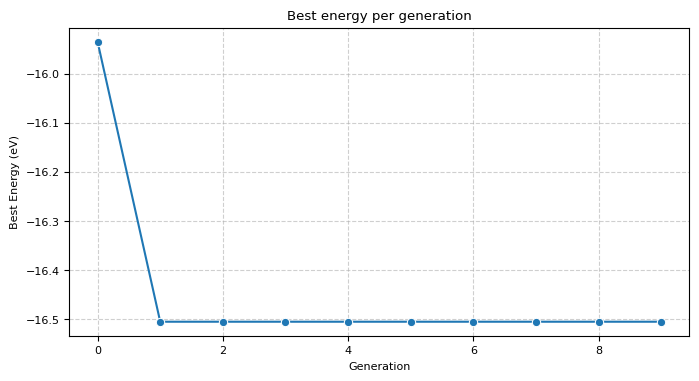

,Results
Initial energy (eV),21.026835
Final best energy (eV),-16.505384
"Improvement vs initial (ΔE, eV)",37.532219
Global best energy (eV),-16.505384
Best generation (1-based),7.000000
Generations run,10.000000


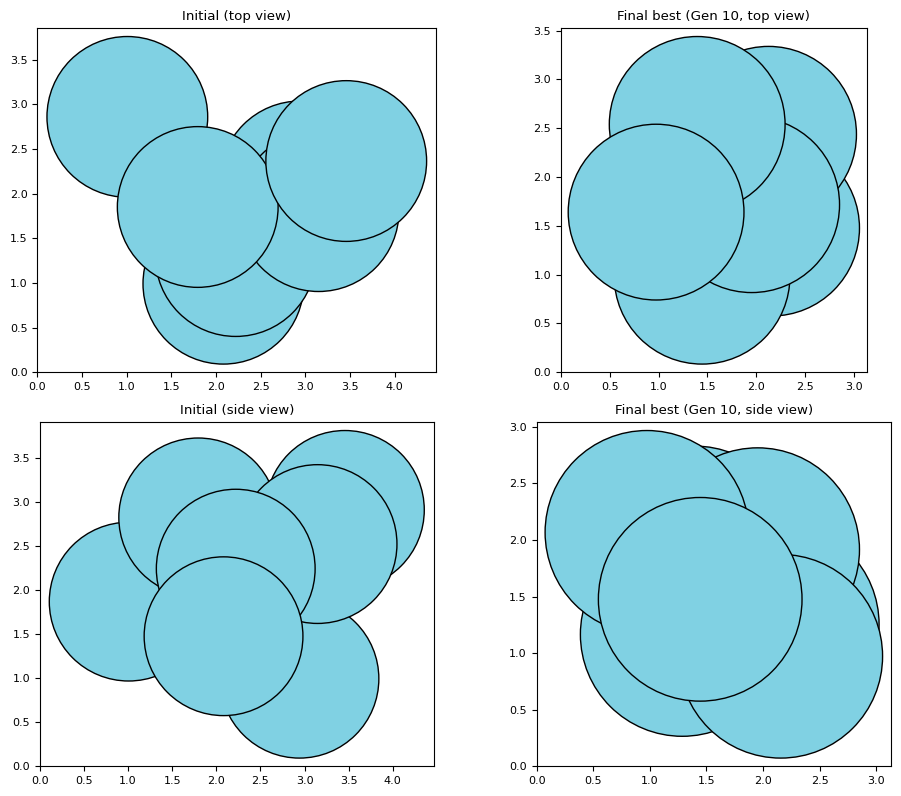

In [131]:
# Analyze output energies and structures
view_results(dst=dst, sort_samples=True, show=False)



Energy Group Analysis - Run 0
Total samples evaluated: 320
Energy groups found: 26
Energy range: -16.505384 to -0.000105 eV
Energy std dev: 3.766545 eV
Energy tolerance: 0.01 eV

Energy groups (sorted by energy):
Rank   Energy (eV)        Count    Frequency   
----------------------------------------------------------------------
1      -16.505384         88        27.50%
2      -15.935043         32        10.00%
3      -15.593211         44        13.75%
4      -15.533060         111       34.69%
5      -13.957931         1          0.31%
6      -12.313458         4          1.25%
7      -12.303335         2          0.62%
8      -10.689080         1          0.31%
9      -10.383100         1          0.31%
10     -10.106419         1          0.31%
11     -9.142866          1          0.31%
12     -9.125728          1          0.31%
13     -9.111504          7          2.19%
14     -7.242859          1          0.31%
15     -7.036897          1          0.31%
16     -7.015921      

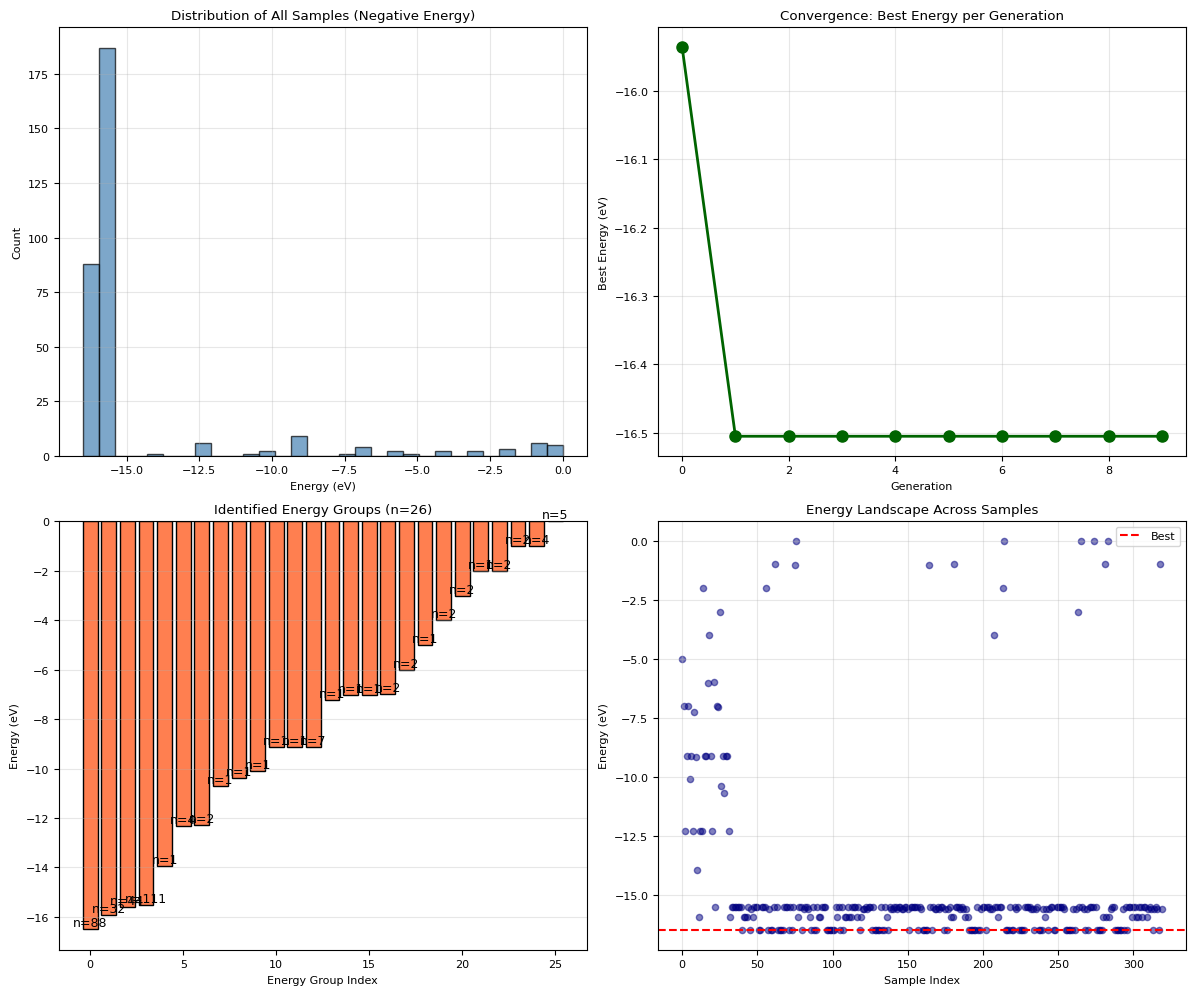

In [132]:
# Analyze ES convergence and minima found
h5_file = evo[0]  # First element of evo tuple is the h5_filename
run_id = evo[1]   # Second element is the run_id

convergence_analysis = analyze_es_energy_groups(h5_file, run_id=run_id, plot=True)